
# Determining and plotting the altitude/azimuth of a celestial object including magnitudes and types of objects for September 2022

This example demonstrates coordinate transformations and the creation of
visibility curves to assist with observing run planning.

In this example, we make a `~astropy.coordinates.SkyCoord` instance for M33.
The altitude-azimuth coordinates are then found using
`astropy.coordinates.EarthLocation` and `astropy.time.Time` objects.

This example is meant to demonstrate the capabilities of the
`astropy.coordinates` package. For more convenient and/or complex observation
planning, consider the `astroplan <https://astroplan.readthedocs.org/>`_
package.


*By: Erik Tollerud, Kelle Cruz*

*License: BSD*


- Author Sylvie Dagoret-Campagne
- Creation : September 12th 2022
- Update 

Let's suppose you are planning to visit picturesque Bear Mountain State Park
in New York, USA. You're bringing your telescope with you (of course), and
someone told you M33 is a great target to observe there. You happen to know
you're free at 11:00 pm local time, and you want to know if it will be up.
Astropy can answer that.

Import numpy and matplotlib. For the latter, use a nicer set of plot
parameters and set up support for plotting/converting quantities.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.visualization import astropy_mpl_style, quantity_support
plt.style.use(astropy_mpl_style)
quantity_support()

%matplotlib inline

Import the packages necessary for finding coordinates and making
coordinate transformations



In [2]:
import astropy.units as u
from astropy.coordinates import Angle
from astropy.time import Time, TimezoneInfo,TimeDelta
from astropy.coordinates import SkyCoord, EarthLocation, AltAz

In [3]:
from astroquery.simbad import Simbad

In [4]:
from astropy.table import Table

In [5]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [6]:
from datetime import datetime
import timezonefinder, pytz
from calendar import monthrange
import calendar

- label lines
https://github.com/cphyc/matplotlib-label-lines

In [7]:
#from labellines import labelLine, labelLines

In [8]:
plt.rcParams["axes.labelsize"]="large"
plt.rcParams["axes.linewidth"]=2.0
plt.rcParams["xtick.major.size"]=8
plt.rcParams["ytick.major.size"]=8
plt.rcParams["ytick.minor.size"]=5
plt.rcParams["xtick.labelsize"]="large"
plt.rcParams["ytick.labelsize"]="large"

plt.rcParams["figure.figsize"]=(12,8)
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.titleweight'] = 'bold'
#plt.rcParams['axes.facecolor'] = 'blue'
plt.rcParams['xtick.direction'] = 'out'
plt.rcParams['ytick.direction'] = 'out'
plt.rcParams['lines.markeredgewidth'] = 0.3 # the line width around the marker symbol
plt.rcParams['lines.markersize'] = 5  # markersize, in points
plt.rcParams['grid.alpha'] = 0.75 # transparency, between 0.0 and 1.0
plt.rcParams['grid.linestyle'] = '-' # simple line
plt.rcParams['grid.linewidth'] = 0.4 # in points
plt.rcParams['font.size'] = 13

# Initialisation:

## Observation location

In [9]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

## Determination of UTC offset from Time zone in Chile

In [10]:
tf = timezonefinder.TimezoneFinder()

In [11]:
timezone_str = tf.certain_timezone_at(lat=latitude.degree, lng=longitude.degree)

In [12]:
timezone_str 

'America/Santiago'

In [13]:
if timezone_str is None:
    print("Could not determine the time zone")
else:
    # Display the current time in that time zone
    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
    timezone = pytz.timezone(timezone_str)
    timezone0 = pytz.timezone('UTC')
    
    dt = datetime.utcnow()
    timeChile_now = datetime.now(timezone)
    
    print("The UTC Time now %s" % dt)
    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

The UTC Time now 2022-09-12 07:31:18.857558
The actual time in America/Santiago is 2022-09-12 04:31:18.857558


In [14]:
utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0  hours


In [15]:
tz_utc_minus_three_hours = TimezoneInfo(utc_offset=int(utcoffset)*u.hour)
tz_utc_minus_three_hours

## Initialisation of Simbad

In [16]:
# to view the list of VOTABLE
# Simbad.list_votable_fields()

In [17]:
Simbad.add_votable_fields('sptype')
Simbad.add_votable_fields('flux(U)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(B)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(V)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(R)') # add the Vega unit Magnitude 
Simbad.add_votable_fields('flux(I)') # add the Vega unit Magnitude 
#Simbad.add_votable_fields('flux_unit(V)')
#Simbad.add_votable_fields('flux_unit(I)')
#Simbad.add_votable_fields('flux_system(V)')
#Simbad.add_votable_fields('flux_system(I)')
#Simbad.add_votable_fields('ubv')  # Johnson UBV system

## Targets

In [18]:
all_target_names_old= ["hd111980","hd101452","hd115169","hd142331",'FEIGE110', 'GD108', 'GD50',
                   'HD009051', 'HD031128','HD074000', 'HD111980', 'HD14943', 'HD160617', 'HD185975',
                   'HD200654', 'HD205905', 'HD37962', 'HD38949', 'HD60753','LTT9491', 'NGC7293', 'SIRIUS', 
                   'WD0308-565','HD009051','HD14943','HD002811','PNG321.0+03.9','HD2811','HD009051','HD14943',
                   'HD031128','LAM LEP','HD37962','mu. Col','HD38949','ETA1 DOR','HD60753','HD074000','HD160617',
                   'HD167060','HD185975','HD200654','HD205905','HD14943','HD031128','LAM LEP','HD37962','mu. Col',
                   'HD38949','ETA1 DOR','HD60753','HD074000','HD111980','HD115169','BD-11 192','HD142331','18SCO',
                   'HD160617','HD167060','HD185975']

all_target_names = ['18SCO', 'BD-11 192', 'ETA1 DOR', 'FEIGE110', 'GD108', 'GD50','HD002811', 'HD009051',
                    'HD031128', 'HD074000', 'HD111980','HD115169', 'HD142331', 'HD14943', 'HD160617','HD167060',
                    'HD185975', 'HD200654', 'HD205905', 'HD2811', 'HD37962', 'HD38949','HD60753', 'LAM LEP',
                    'LTT9491', 'NGC7293', 'PNG321.0+03.9','SIRIUS', 'WD0308-565', 'HD101452',
                    'mu. Col']

NTargets=len(all_target_names)

In [19]:
print(f"Number of targets : {NTargets}")

Number of targets : 31


## Get coordinates

In [20]:
all_target_locations = [ SkyCoord.from_name(target_name) for target_name in all_target_names]

In [21]:
all_ra=[]
all_dec=[]
for target_loc in all_target_locations:
    all_ra.append(target_loc.ra)
    all_dec.append(target_loc.dec)

## Find magnitudes

In [22]:
all_Vmag = []
all_types = []
all_target_tagnames = []
for target_name in all_target_names:
    result_table = Simbad.query_object(target_name)
    all_Vmag.append(result_table['FLUX_V'][0])
    all_types.append(result_table['SP_QUAL'][0]) 
    tagname =  target_name + ", t=" + result_table['SP_QUAL'][0] + ", m=" + str(result_table['FLUX_V'][0])
    print(tagname)
    all_target_tagnames.append(tagname)

18SCO, t=B, m=5.5
BD-11 192, t=C, m=9.993
ETA1 DOR, t=C, m=5.69
FEIGE110, t=B, m=11.5
GD108, t=D, m=13.563
GD50, t=C, m=14.063
HD002811, t=C, m=7.5
HD009051, t=D, m=8.92
HD031128, t=D, m=9.14
HD074000, t=D, m=9.66
HD111980, t=C, m=8.38
HD115169, t=C, m=9.2
HD142331, t=C, m=8.75
HD14943, t=C, m=5.898
HD160617, t=D, m=8.73
HD167060, t=C, m=8.92
HD185975, t=C, m=8.1
HD200654, t=C, m=9.11
HD205905, t=C, m=6.74
HD2811, t=C, m=7.5
HD37962, t=C, m=7.85
HD38949, t=C, m=7.8
HD60753, t=C, m=6.68
LAM LEP, t=C, m=4.29
LTT9491, t=C, m=14.111
NGC7293, t=C, m=13.524
PNG321.0+03.9, t=C, m=11.64
SIRIUS, t=C, m=-1.46
WD0308-565, t=D, m=14.14
HD101452, t=E, m=8.2
mu. Col, t=C, m=5.18


## Build table

In [23]:
all_ra[0].to_string(u.hour)

'16h15m37.27027557s'

In [24]:
from astropy.table import Table
t = Table()
t["target"] = all_target_names
t["tag"] = all_target_tagnames
t["types"] = all_types
t["Vmag"]  = all_Vmag 
t["ra"]    = all_ra 
t["dec"]    = all_dec 
t["ra_hms"] = [ ra_.to_string(u.hour) for ra_ in all_ra]
t["dec_dms"] = [ dec_.to_string(u.degree) for dec_ in all_dec]

In [25]:
t['ra'].info.format = '9.6f'
t['dec'].info.format = '9.6f'
t['Vmag'].info.format = '4.2f'

## Observation Date

In [26]:
NYEAR=2022
NMONTH=9
NDAY=12

In [27]:
night_obs = datetime(NYEAR, NMONTH, NDAY, 0, 0)
night_obs_midnight= datetime(NYEAR, NMONTH, NDAY, 23, 59,59,tzinfo = tz_utc_minus_three_hours)

In [28]:
night_obs_midnight

datetime.datetime(2022, 9, 12, 23, 59, 59, tzinfo=<astropy.time.formats.TimezoneInfo object at 0x7f83840b0850>)

In [29]:
night_obs_str=night_obs.strftime("%Y-%m-%d %H:%M:%S")
night_obs_str

'2022-09-12 00:00:00'

In [30]:
night_obs_midnight_str=night_obs_midnight.strftime("%Y-%m-%d %H:%M:%S")
night_obs_midnight_str

'2022-09-12 23:59:59'

## Compute UTC and Sideral Time at local midnight

In [31]:
tz_utc = TimezoneInfo() 
print("Local time in Standiago in summer (GMT-3) : ",night_obs_midnight)
print("Time in UTC                               : ",night_obs_midnight.astimezone(tz_utc))

Local time in Standiago in summer (GMT-3) :  2022-09-12 23:59:59-03:00
Time in UTC                               :  2022-09-13 02:59:59+00:00


In [32]:
t_lsst = Time(night_obs_midnight.astimezone(tz_utc), scale='utc',location=lsst_location)
t_sidereal_lsst = t_lsst.sidereal_time('apparent')  
print("Sideral Time :",t_sidereal_lsst)

Sideral Time : 21h45m23.84545976s


In [33]:
print("Sideral Time :",Angle(t_sidereal_lsst).to(u.degree))

Sideral Time : 326d20m57.68189641s


In [34]:
print("Sideral Time :",Angle(t_sidereal_lsst).degree)

Sideral Time : 326.3493560823373


In [35]:
# To check
#t_lsst = Time('2022-09-13 02:59:59', scale='utc',location=('-70.73668333d', '-30.24074167d'))
#t_lsst.sidereal_time('apparent') 

## Filter the rows to select observable targets

In [36]:
MarginAngle = Angle(6.0,u.hour)
MarginAngle

<Angle 6. hourangle>

In [37]:
all_flag_select = []
for row in t:
    ra_angle = Angle(row['ra'],u.degree)
    ra_min = (t_sidereal_lsst - MarginAngle).degree*u.deg
    ra_max = (t_sidereal_lsst + MarginAngle).degree*u.deg
    #print(row['ra'],ra_angle.hour)
    #print(ra_min,ra_max)
    flag = ra_angle.is_within_bounds(ra_min,ra_max)
    #print(flag)
    all_flag_select.append(flag)                

In [38]:
t["select"] = all_flag_select

In [39]:
cut = t["select"] == True

In [40]:
# SkyCoords for selected target (no ordering)
selected_target_locations = []
for idx in range(NTargets):
    if t[idx]["select"]:
        selected_target_locations.append(all_target_locations[idx])

In [41]:
t=t[cut]
NTargets=len(t)

In [42]:
print(f"Number of targets : {NTargets}")

Number of targets : 10


In [43]:
t

target,tag,types,Vmag,ra,dec,ra_hms,dec_dms,select
,,,,deg,deg,,,
str13,str27,str1,float32,float64,float64,str18,str19,bool
18SCO,"18SCO, t=B, m=5.5",B,5.50,243.905293,-8.369439,16h15m37.27027557s,-8d22m09.98212543s,True
FEIGE110,"FEIGE110, t=B, m=11.5",B,11.50,349.993332,-5.165603,23h19m58.39968443s,-5d09m56.17114286s,True
HD142331,"HD142331, t=C, m=8.75",C,8.75,238.582452,-8.580381,15h54m19.78847661s,-8d34m49.3708494s,True
HD160617,"HD160617, t=D, m=8.73",D,8.73,265.705514,-40.320973,17h42m49.3234249s,-40d19m15.50383466s,True
HD167060,"HD167060, t=C, m=8.92",C,8.92,274.433929,-61.708783,18h17m44.14300226s,-61d42m31.6201028s,True
HD185975,"HD185975, t=C, m=8.1",C,8.10,307.078083,-87.472205,20h28m18.73982642s,-87d28m19.93756732s,True
HD200654,"HD200654, t=C, m=9.11",C,9.11,316.644797,-49.963967,21h06m34.75132545s,-49d57m50.280288s,True
HD205905,"HD205905, t=C, m=6.74",C,6.74,324.792296,-27.306573,21h39m10.15095117s,-27d18m23.66264335s,True


In [44]:
# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NTargets)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NTargets), alpha=1)

## Time zone at observation

In [45]:
timezone.utcoffset

<bound method DstTzInfo.utcoffset of <DstTzInfo 'America/Santiago' LMT-1 day, 19:17:00 STD>>

In [46]:
night_obs_midnight

datetime.datetime(2022, 9, 12, 23, 59, 59, tzinfo=<astropy.time.formats.TimezoneInfo object at 0x7f83840b0850>)

In [47]:
#if timezone_str is None:
#    print("Could not determine the time zone")
#else:
#    # Display the current time in that time zone
#    
    #tz = pytz.timezone('Europe/Berlin')
    #berlin_now = datetime.now(tz)
    
#    timezone = pytz.timezone(timezone_str)
#    timezone0 = pytz.timezone('UTC')
#    
#    dt = night_obs_midnight
#    
#    print("The UTC Time at observation %s" % dt)
#    print("The actual time in %s is %s" % (timezone_str, dt + timezone.utcoffset(dt)))

In [48]:
#utcoffset=timezone.utcoffset(dt).total_seconds()/60./60.
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0  hours


In [49]:
utcoffset=utcoffset*u.hour  # need hours units
print("The UTC offset in Chile is ",utcoffset," hours")

The UTC offset in Chile is  -3.0 h  hours


## Observation Location

In [50]:
LSSTNAME='Cerro Pachon'
lsst_location=EarthLocation.of_site(LSSTNAME)
longitude=lsst_location.lon
latitude=lsst_location.lat
altitude=lsst_location.height

In [51]:
cerro_pachon = EarthLocation(lat=latitude.degree*u.deg, lon=longitude.degree*u.deg, height=altitude)

## Check Position of target at midnight

http://catserver.ing.iac.es/staralt/

# Observation frame

### Initialisation

In [52]:
midnight_utc = Time(night_obs_midnight_str) - utcoffset
delta_midnight = np.linspace(-12, 12, 1000)*u.hour
sideral_times = Angle(t_sidereal_lsst) + Angle(delta_midnight)
times_evening_to_morning = midnight_utc + delta_midnight
frame_evening_to_morning = AltAz(obstime=times_evening_to_morning, location=cerro_pachon)

### Sun frame

In [53]:
from astropy.coordinates import get_sun
sunaltazs_evening_to_morning = get_sun(times_evening_to_morning).transform_to(frame_evening_to_morning)

### Moon frame

In [54]:
from astropy.coordinates import get_moon
moon_evening_to_morning = get_moon(times_evening_to_morning)
moonaltazs_evening_to_morning = moon_evening_to_morning.transform_to(frame_evening_to_morning)

### Target frame

In [55]:
# use selected observable targets according their SkyCoords for each target
all_target_altazs_evening_to_morning = [target_location.transform_to(frame_evening_to_morning) for target_location in  selected_target_locations ]

## compute distance to the moon

In [56]:
all_target_distancetomoon_evening_to_morning = [] 

num_target=0
for targetcoordinateseries in all_target_altazs_evening_to_morning: 
    print(num_target,len(targetcoordinateseries))
    N_coord = len(targetcoordinateseries)
    idx_coord = 0
    all_distances_sep = []
    for idx_coord in range(N_coord):
        distance_sep=targetcoordinateseries[idx_coord].separation(moonaltazs_evening_to_morning[idx_coord])
        all_distances_sep.append(distance_sep.degree)
    all_target_distancetomoon_evening_to_morning.append(all_distances_sep) 
    num_target+=1

0 1000
1 1000
2 1000
3 1000
4 1000
5 1000
6 1000
7 1000
8 1000
9 1000


# Order according increasing maxinum rise time

In [58]:
all_timemax=np.zeros(NTargets)
all_altitudesmax=np.zeros(NTargets)
for idx in np.arange(NTargets):
    altitudes=all_target_altazs_evening_to_morning[idx].alt
    idx_max=np.where(altitudes==altitudes.max())[0][0]
    all_timemax[idx]=delta_midnight[idx_max].value
    all_altitudesmax[idx]=altitudes.max().degree

In [59]:
Angle(altitudes.max()).degree

80.48001187325995

In [60]:
all_timemax

array([-5.46546547,  1.5975976 , -5.82582583, -4.        , -3.42342342,
       -1.11711712, -0.61261261, -0.08408408,  1.57357357,  0.75675676])

In [61]:
sorted_indexes=np.argsort(all_timemax)
sorted_indexes

array([2, 0, 3, 4, 5, 6, 7, 9, 8, 1])

In [62]:
sorted_all_timemax=sorted(all_timemax)
sorted_all_timemax

[-5.8258258258258255,
 -5.465465465465465,
 -4.0,
 -3.423423423423424,
 -1.1171171171171164,
 -0.6126126126126135,
 -0.08408408408408441,
 0.7567567567567561,
 1.573573573573574,
 1.5975975975975967]

# Plot standard observation elevation angle

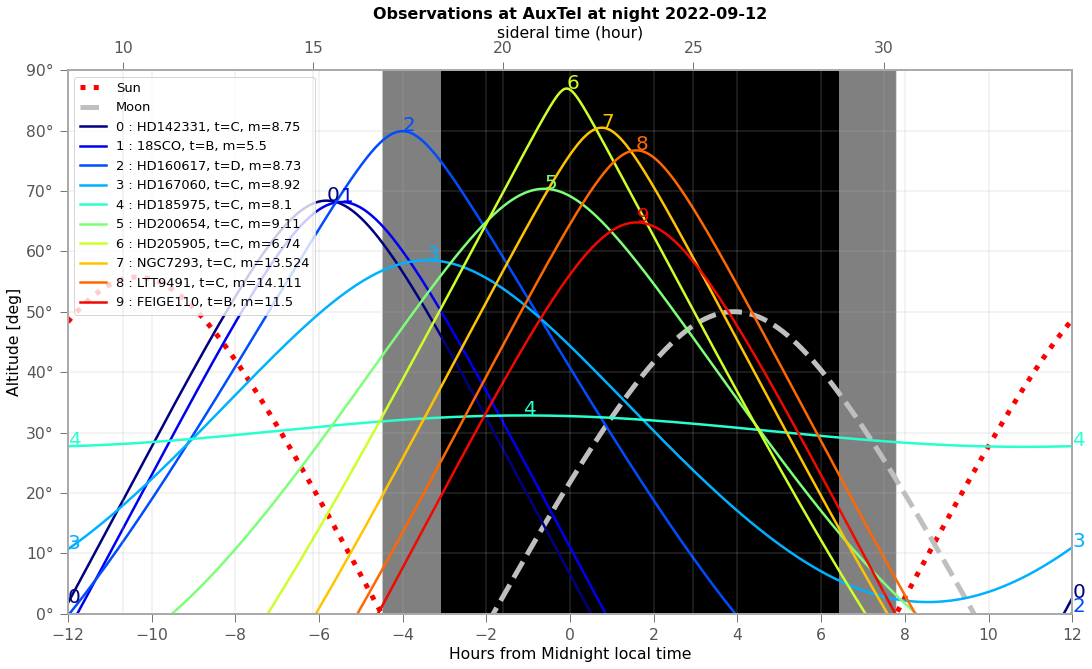

In [63]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(1,1,1)
# plot sun
ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)

rank=0
for idx in sorted_indexes:
    label=str(rank)+" : "+t[idx]['tag']
    ax.plot(delta_midnight, all_target_altazs_evening_to_morning[idx].alt,label=label, lw=2.5,color=all_colors[rank])

    if all_target_altazs_evening_to_morning[idx].alt[-1]>0:
        ax.text(delta_midnight[-1], all_target_altazs_evening_to_morning[idx].alt[-1], f'{rank}',color=all_colors[rank],fontsize=20)
    if all_target_altazs_evening_to_morning[idx].alt[0]>0:
        ax.text(delta_midnight[0], all_target_altazs_evening_to_morning[idx].alt[0], f'{rank}',color=all_colors[rank],fontsize=20)
    if all_altitudesmax[idx]:
        ax.text(all_timemax[idx], all_altitudesmax[idx], f'{rank}',color=all_colors[rank],fontsize=20)
    
    rank+=1
    

ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 90*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper left')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 90*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('Altitude [deg]')
title = "Observations at AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
figname="AuxtelStarAlt_{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()

## Distance to moon

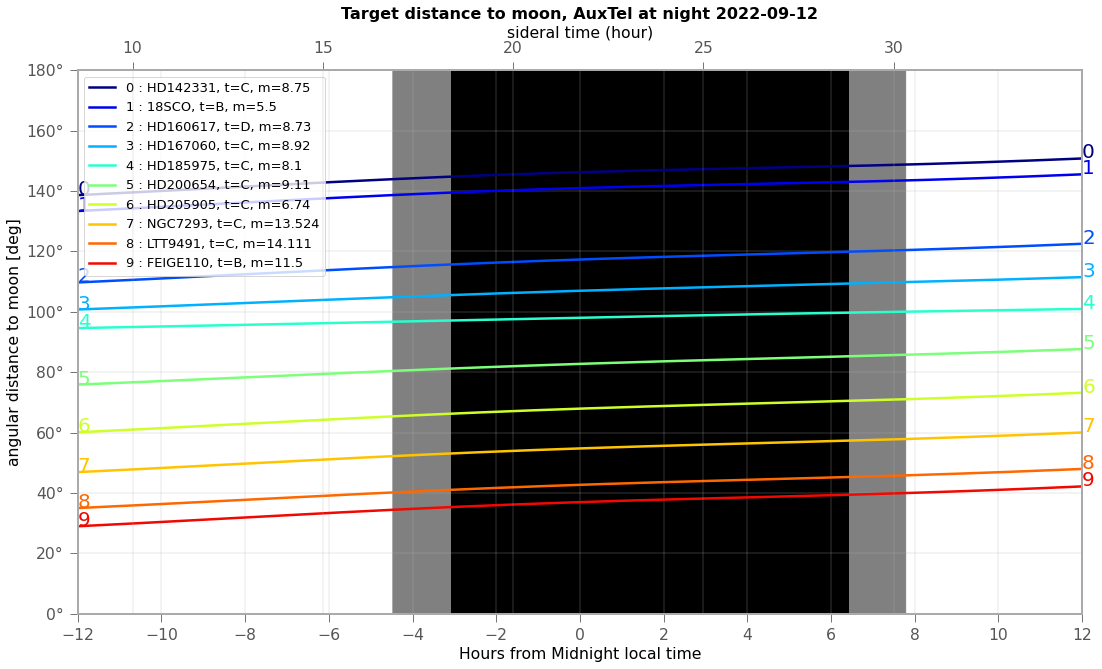

In [64]:
fig = plt.figure(figsize=(18,10))
ax=fig.add_subplot(1,1,1)
# plot sun
#ax.plot(delta_midnight, sunaltazs_evening_to_morning.alt, color='r', ls=":",label='Sun',lw=5)
#plot moon
#ax.plot(delta_midnight, moonaltazs_evening_to_morning.alt, color=[0.75]*3, ls='--', label='Moon',lw=5)

rank=0
for idx in sorted_indexes:
    label=str(rank)+" : "+t[idx]['tag']
    ax.plot(delta_midnight, all_target_distancetomoon_evening_to_morning[idx],label=label, lw=2.5,color=all_colors[rank])

    #if all_target_altazs_evening_to_morning[idx].alt[-1]>0:
    ax.text(delta_midnight[-1], all_target_distancetomoon_evening_to_morning[idx][-1], f'{rank}',color=all_colors[rank],fontsize=20)
    #if all_target_altazs_evening_to_morning[idx].alt[0]>0:
    ax.text(delta_midnight[0], all_target_distancetomoon_evening_to_morning[idx][0], f'{rank}',color=all_colors[rank],fontsize=20)
    #if all_altitudesmax[idx]:
    #    ax.text(all_timemax[idx], all_altitudesmax[idx], f'{rank}',color=all_colors[rank],fontsize=20)
    
    rank+=1
    

ax.fill_between(delta_midnight, 0*u.deg, 180*u.deg,sunaltazs_evening_to_morning.alt < -0*u.deg, color='0.5', zorder=0)
ax.fill_between(delta_midnight, 0*u.deg, 180*u.deg,sunaltazs_evening_to_morning.alt < -18*u.deg, color='k', zorder=0)

ax.legend(loc='upper left')
ax.set_xlim(-12*u.hour, 12*u.hour)
ax.set_xticks((np.arange(13)*2-12)*u.hour)
ax.set_ylim(0*u.deg, 180*u.deg)
ax.set_xlabel('Hours from Midnight local time')
ax.set_ylabel('angular distance to moon [deg]')
title = "Target distance to moon, AuxTel at night " + night_obs_str.split(" ")[0]
ax.set_title(title)
ax2 = ax.twiny()
ax2.plot([sideral_times[0].hour,sideral_times[-1].hour],[0,0])
ax2.set_xlabel("sideral time (hour)")
figname="AuxtelStarAltDistToMoon_{:4d}_{:d}_{:d}.png".format(NYEAR,NMONTH,NDAY)

plt.savefig(figname)
plt.show()

# Create astropy Table

In [65]:
t2 = Table()

In [66]:
t2["name"] = [t[sorted_indexes[idx]]["target"] for idx in range(NTargets)]
t2["type"] = [t[sorted_indexes[idx]]["types"] for idx in range(NTargets)]
t2["Vmag"] = [t[sorted_indexes[idx]]["Vmag"] for idx in range(NTargets)] 
t2["ra"] = [t[sorted_indexes[idx]]["ra"] for idx in range(NTargets)]
t2["dec"] = [t[sorted_indexes[idx]]["dec"] for idx in range(NTargets)]
t2["ra_hms"] = [t[sorted_indexes[idx]]["ra_hms"] for idx in range(NTargets)]
t2["dec_dms"] = [t[sorted_indexes[idx]]["dec_dms"] for idx in range(NTargets)]
t2["tculmin"] = all_timemax

In [67]:
t2["ra"].info.format ='5.3f'
t2["dec"].info.format ='5.3f'
t2["Vmag"].info.format ='5.3f'
t2["tculmin"].info.format ='5.3f'

In [68]:
#t2.show_in_notebook()

In [69]:
t2

name,type,Vmag,ra,dec,ra_hms,dec_dms,tculmin
str8,str1,float32,float64,float64,str18,str19,float64
HD142331,C,8.750,238.582,-8.580,15h54m19.78847661s,-8d34m49.3708494s,-5.465
18SCO,B,5.500,243.905,-8.369,16h15m37.27027557s,-8d22m09.98212543s,1.598
HD160617,D,8.730,265.706,-40.321,17h42m49.3234249s,-40d19m15.50383466s,-5.826
HD167060,C,8.920,274.434,-61.709,18h17m44.14300226s,-61d42m31.6201028s,-4.000
HD185975,C,8.100,307.078,-87.472,20h28m18.73982642s,-87d28m19.93756732s,-3.423
HD200654,C,9.110,316.645,-49.964,21h06m34.75132545s,-49d57m50.280288s,-1.117
HD205905,C,6.740,324.792,-27.307,21h39m10.15095117s,-27d18m23.66264335s,-0.613
NGC7293,C,13.524,337.411,-20.837,22h29m38.54540472s,-20d50m13.74724241s,-0.084
LTT9491,C,14.111,349.897,-17.091,23h19m35.38818613s,-17d05m28.46557338s,1.574
